In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
radius=10.
Tstart_Ursini_2015='2002-01-01T00:00:00'
Tstop_Ursini_2015='2015-01-31T00:00:00'

E1_keV=20.
E2_keV=300.
host='www.astro.unige.ch/cdci/astrooda/dispatch-data'
rebin=10 # minimal significance in energy bin, for spectral plotting

In [11]:
disp=DispatcherAPI(host=host)

In [19]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(Tstart,Tstop,ra,dec,radius):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000'
    print(url+params)
    return requests.get(url+params).json()

In [21]:
scwlist=queryxtime(Tstart=Tstart_Ursini_2015,Tstop=Tstop_Ursini_2015,ra=ra,dec=dec,radius=radius)
m=len(scwlist)
pointings_osa10=[]
pointings_osa11=[]

for i in range(m):
    if scwlist[i][-2:]=='10':
        if(int(scwlist[i][:4])<1626):
            pointings_osa10.append(scwlist[i]+'.001')
        else:
            pointings_osa11.append(scwlist[i]+'.001')
#else:abs
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m_osa10=len(pointings_osa10)
m_osa11=len(pointings_osa11)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2002-01-01T00:00:00/2015-01-31T00:00:00?&ra=88.0474&dec=-7.456247&radius=10.0&min_good_isgri=1000


In [22]:
def chunk_swc_list(lst, size):
    _l = [lst[x:x+size] for x in range(0, len (lst), size)]
    for ID,_ in enumerate(_l):
        _l[ID]=','.join(_)
       
    return _l

In [23]:
scw_lists_osa10=chunk_swc_list(pointings_osa10, 50)
scw_lists_osa11=chunk_swc_list(pointings_osa11, 50)


In [24]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists_osa10[0],
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,048300060010.

In [25]:
data.dispatcher_catalog_1.table



meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,6.663077354431152,79.04800415039062,-0.15556472539901733,-32768,2,0,0.0002800000074785203
4,H 0614+091,16.865127563476562,94.28309631347656,9.128047943115234,-32768,2,0,0.0002800000074785203
14,NGC 2110,16.837064743041992,88.04612731933594,-7.463523864746094,-32768,2,0,0.0002800000074785203


In [26]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n=='NEW_1'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)

nrows=len(data.dispatcher_catalog_1.table['src_names'])
print(nrows)
print(FLAG)

3
1


In [27]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row((0,'3C 279',0,ra,dec,0,2,0,0))
    
data.dispatcher_catalog_1.table    

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,6.663077354431152,79.04800415039062,-0.15556472539901733,-32768,2,0,0.0002800000074785203
4,H 0614+091,16.865127563476562,94.28309631347656,9.128047943115234,-32768,2,0,0.0002800000074785203
14,NGC 2110,16.837064743041992,88.04612731933594,-7.463523864746094,-32768,2,0,0.0002800000074785203


In [28]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [29]:
spectrum_results=[]
for i in range(len(scw_lists_osa10)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa10[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0
048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,04830006001

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=8384306324884216639  39  

query done succesfully!
3
071800340010.001,071800350010.001,071800360010.001,071800370010.001,071800380010.001,071800390010.001,071800400010.001,071800410010.001,071800420010.001,071800430010.001,071800440010.001,071800450010.001,071800460010.001,071800470010.001,071800480010.001,071800490010.001,071800500010.001,071800510010.001,071800520010.001,071800530010.001,071800540010.001,071800550010.001,071800560010.001,071800570010.001,071800580010.001,071900120010.001,071900130010.001,071900140010.001,071900150010.001,071900160010.001,071900170010.001,071900180010.001,071900190010.001,071900200010.001,071900210010.001,071900220010.001,071900230010.001,071900240010.001,071900250010.001,071900260010.001,071900270010.001,071900280010.001,071900290010.001,071900300010.001,071900310010.001,071900320010.001,071900330010.001,071900340010.001,085400180010.001,0

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=8123773922708518455  55  

query done succesfully!
6
097300500010.001,097300890010.001,097300900010.001,097300910010.001,097300920010.001,097300930010.001,097300940010.001,097300950010.001,097300960010.001,097300970010.001,097300980010.001,097400030010.001,097400040010.001,097400050010.001,097400060010.001,097400070010.001,097400080010.001,097400090010.001,097400100010.001,097400110010.001,097400120010.001,097400510010.001,097400520010.001,097400530010.001,097400540010.001,097400550010.001,097400560010.001,097400570010.001,097400580010.001,097400590010.001,097400600010.001,097500230010.001,097500240010.001,097500250010.001,097500260010.001,097500270010.001,097500280010.001,097500290010.001,097500300010.001,097500310010.001,097500320010.001,097500370010.001,097500380010.001,097500390010.001,097500400010.001,097500410010.001,097500420010.001,097500430010.001,097500440010.001,0

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-4410648279789269601  01  

query done succesfully!
9
127000780010.001,127000790010.001,127000800010.001,127500680010.001,127500760010.001,127500770010.001,127500780010.001,127500790010.001,127500860010.001,127500870010.001,127500880010.001,127800630010.001,127800640010.001,127800650010.001,127800660010.001,127800830010.001,127800840010.001,127800850010.001,127800860010.001,127800870010.001,127800880010.001,127800890010.001,127800910010.001,127800920010.001,127900070010.001,127900280010.001,127900370010.001,127900380010.001,128100060010.001,128100070010.001,128100080010.001,128100090010.001,128100100010.001,128100110010.001,128100120010.001,128100130010.001,128100150010.001,128100160010.001,128100170010.001,128100180010.001,128100190010.001,128100200010.001,128100220010.001,128100290010.001,128100300010.001,128100310010.001,131700340010.001,131700430010.001,132600040010.001,

the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=-6580052633810195035  35  

query done succesfully!
12
144400320010.001,144400330010.001,144400340010.001,144400370010.001,144400380010.001,144400390010.001,144400400010.001,144400410010.001,144400420010.001,144400430010.001,144400480010.001,144400490010.001,144400500010.001,144400510010.001,144400520010.001,144500050010.001,144500060010.001,144500070010.001,144500080010.001,144500090010.001,144500100010.001,144500140010.001,144500150010.001,144500160010.001,144500170010.001,144500180010.001,144500190010.001,144500200010.001,144500210010.001,144500250010.001,144500260010.001,144500270010.001,144500280010.001,144500290010.001,144500300010.001,144500310010.001,144500340010.001,144500350010.001,144500360010.001,144500370010.001,144500380010.001,144500390010.001,144500400010.001,144500460010.001,144500470010.001,144500480010.001,144500490010.001,144500500010.001,144500510010.001

the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=1576592991204858763  63  

query done succesfully!
15
146300590010.001,146300600010.001,150000470010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 146300590010.001,146300600010.001,150000470010.001
query_type Real
osa_version OSA10.2
RA 88.0474
DEC -7.456247
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[3, 4, 14], ["Ark 120", "H 0614+091", "NGC 2110"], [6.663077354431152, 16.865127563476562, 16.837064743041992], [79.04800415039062, 94.28309631347656, 88.04612731933594], [-0.15556472539901733, 9.128047943115234, -7.463523864746094], [-32768, -32768, -32768], [2, 2, 2], [0, 0, 0], [0.0002800000074785203, 0.0002800000074785203, 0.0002800000074785203]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "E

In [31]:
d=spectrum_results[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

                                             

0 1 2


In [32]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa10)):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

62
0 112004.5226494027
1 110147.9947506899
2 106118.0555422054
3 113143.3280120063
4 112157.294877559
5 96828.94506904678
6 62619.93384876712
7 61198.2749177427
8 112383.5909443086
9 121174.9784667263
10 120590.7816143036
11 114387.4684778941
12 120698.1348872847
13 115804.4614346624
14 112722.0648674613
15 6627.75016956708
Total exposure: 1598607.5805296279


/Users/orion/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [33]:
print(rate)
print(err)

[ 0.         -0.16722538  0.07527122  0.09694314  0.18389575  0.16756435
  0.10327081  0.12222497  0.11876284  0.12093259  0.11809003  0.12109989
  0.12593901  0.10784724  0.19906828  0.16420345  0.14941038  0.13270491
  0.23822632  0.17786573  0.15410522  0.14340381  0.12650943  0.11430537
  0.11804463  0.09806883  0.08363963  0.05389664  0.04252981  0.04450531
  0.04096809  0.0338199   0.0481851   0.05599638  0.07164562  0.06909671
  0.0560432   0.04581282  0.04380478  0.02807773  0.02480948  0.0187451
  0.0210952   0.01688298  0.00611645  0.00181198  0.00840346  0.00765327
  0.00830661  0.00211778  0.00225584  0.00478307  0.00766911  0.00697504
 -0.00234423  0.00230364 -0.00066692  0.00074318  0.00171616 -0.00749598
 -0.00970486  0.00121866]
[0.         0.18707277 0.08766796 0.04559547 0.02902199 0.02079587
 0.01578115 0.01269566 0.01079402 0.00948189 0.00857471 0.00779436
 0.00720537 0.00668965 0.0084526  0.00732452 0.00642682 0.00582794
 0.00732082 0.00650051 0.00610224 0.0059025 

In [34]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [35]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [36]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()


In [62]:
print(name)

NGC2110


In [61]:
!./spectrum_fit_osa10.sh $name 20

/bin/sh: ./spectrum_fit_osa10.sh: No such file or directory


In [ ]:
name=name+'_ursini'

In [ ]:
!./spectrum_fit_osa10_ursini.sh $name 20

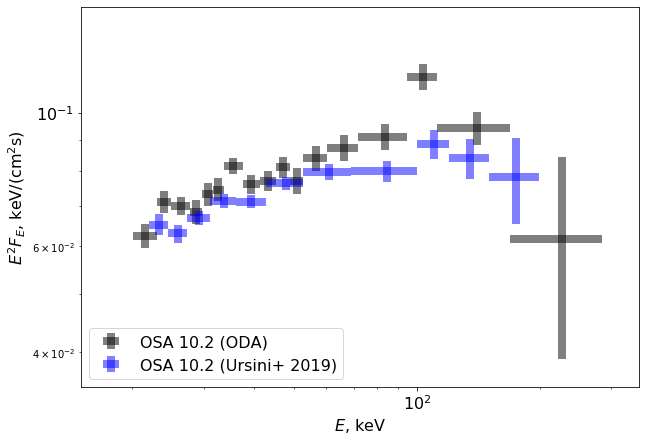

In [63]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt('NGC2110_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5,label='OSA 10.2 (ODA)')
#plt.plot(en,mo,color='black',linewidth=4)

spectrum=np.genfromtxt('NGC2110_ursini_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='blue',alpha=0.5,label='OSA 10.2 (Ursini+ 2019)')
#plt.plot(en,mo,color='blue',linewidth=4)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(3.5E-2,1.5E-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.savefig(name+'_spectrum.pdf',format='pdf',dpi=100)


